<a href="https://colab.research.google.com/github/satwik-goyal/Robotics-CIFAR100-Classification/blob/main/CR_CWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

In [1]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape , Multiply, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D, GlobalAveragePooling2D , Add, UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:


 # Load CIFAR100 dataset
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# # Normalize pixel values
# X_train = X_train.astype('float32') / 255
# X_test = X_test.astype('float32') / 255
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)


# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)




169001437/169001437 [==============================] - 6s 0us/step


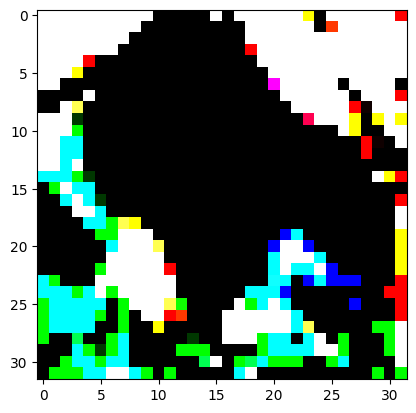

In [3]:
Selected_Image = 13422
image = x_train[Selected_Image]
plt.imshow(image)
plt.show()


## Pretrained

In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))


optimizer = Adam(1e-2)
model.compile(optimizer = optimizer , metrics = ["accuracy"] , loss='categorical_crossentropy')


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [5]:

model.fit(x_train, y_train, batch_size=64,
                                  epochs=25,
                                  validation_data=(x_test, y_test))

Epoch 1/25
782/782 [==============================] - 172s 203ms/step - loss: 1.5139 - accuracy: 0.5767 - val_loss: 1.1540 - val_accuracy: 0.6621
Epoch 2/25
782/782 [==============================] - 156s 200ms/step - loss: 0.9737 - accuracy: 0.7089 - val_loss: 1.1421 - val_accuracy: 0.6850
Epoch 3/25
782/782 [==============================] - 156s 200ms/step - loss: 0.8387 - accuracy: 0.7469 - val_loss: 0.9184 - val_accuracy: 0.7330
Epoch 4/25
782/782 [==============================] - 156s 200ms/step - loss: 0.7595 - accuracy: 0.7692 - val_loss: 0.9098 - val_accuracy: 0.7385
Epoch 5/25
782/782 [==============================] - 156s 200ms/step - loss: 0.6975 - accuracy: 0.7854 - val_loss: 0.8838 - val_accuracy: 0.7495
Epoch 6/25
782/782 [==============================] - 156s 200ms/step - loss: 0.6487 - accuracy: 0.7999 - val_loss: 0.9275 - val_accuracy: 0.7387
Epoch 7/25
782/782 [==============================] - 156s 200ms/step - loss: 0.6051 - accuracy: 0.8091 - val_loss: 0.9216 -

KeyboardInterrupt: 

In [ ]:
history = pre_model.evaluate(X_test , y_test)

313/313 [==============================] - 5s 15ms/step - loss: 6.5759 - accuracy: 0.3407
